# Demographic Analysis
**Strategies:** 
* Following the function described in the 6th exercise, the King County demographics will be downloaded by using the respective FIPS code.
* The interesting demographics include the Total Population as well as divided by Sex,and Race. Some races will be merging together after examine distribution. The 

In [2]:
#pip install censusdata

  Using cached CensusData-1.15.post1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [4]:
# import libraries
import numpy as np
import pandas as pd
import censusdata

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import fiona

In [6]:
# census data downloader function

def get_census_data(tables, state, county, year=2019):

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    return data

def get_census_tract_geom(state_fips, county_fips):

    # find state and county fips here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
    
    # Download the census tract shapefiles
    tracts = gpd.read_file(f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip')

    # set index as tract
    tracts = tracts.rename(columns={'TRACTCE':'Tract'}).set_index('Tract')

    # Filter to only King County
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts[['geometry']]

    return tracts

In [7]:
# Define the state and county for Seattle
state_fips = '53'  # FIPS code for Washington
county_fips = '033'  # FIPS code for King County

## Interest demographics
* Population
* Race: White, Black, Asian, and (see distribution for merging)
* Below poverty level
* Median Income
* Median GrossRent
* Median Home Value
* Unemployment Status
* Transportion to work
  - Car
  - Transit
  - Bicycle
  - Walked
  - WFH

In [8]:
tables = {
'B01003_001E': 'TotalPopulation',
    
'B02001_002E': 'Race:WhiteAlone',
'B02001_003E': 'Race:BlackAlone',
'B02001_004E': 'Race:AmericanIndianAlaskaNativeAlone',
'B02001_005E': 'Race:AsianAlone',
'B02001_006E': 'Race:NativeHawaiianPacificIslanderAlone',
'B02001_007E': 'Race:SomeOtherRaceAlone',
'B02001_008E': 'Race:TwoOrMoreRaces',
    
'B17001_002E': 'BelowPovertyLevel', 
'B05001_006E': 'Immigration',
'B23025_005E': 'Umemployment',
    
'B19013_001E': 'MedianIncome',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',


'B08006_002E': 'ToWork:Car',
'B08006_008E': 'ToWork:Transit',
'B08006_014E': 'ToWork:Bike',
'B08006_015E': 'ToWork:Walk',
'B08006_017E': 'ToWork:WFH',
}

In [9]:
# get tracts data
census_data = get_census_data(tables, state_fips, county_fips)
census_data.sort_values(by='Tract')

,Name,TotalPopulation,Race:WhiteAlone,Race:BlackAlone,Race:AmericanIndianAlaskaNativeAlone,Race:AsianAlone,Race:NativeHawaiianPacificIslanderAlone,Race:SomeOtherRaceAlone,Race:TwoOrMoreRaces,BelowPovertyLevel,Immigration,Umemployment,MedianIncome,MedianGrossRent,MedianHomeValue,ToWork:Car,ToWork:Transit,ToWork:Bike,ToWork:Walk,ToWork:WFH
Tract,,,,,,,,,,,,,,,,,,,,
000100,"Census Tract 1, King County, Washington",8202,4537,1396,39,1202,0,272,756,996,1138,357,55143,1345,615400,2919,1053,161,122,243
000200,"Census Tract 2, King County, Washington",8779,6000,613,36,1168,0,387,575,617,998,287,77463,1578,469600,2973,1211,141,137,375
000300,"Census Tract 3, King County, Washington",2953,2042,140,0,484,0,27,260,209,170,23,100917,1432,502100,1225,290,22,178,99
000401,"Census Tract 4.01, King County, Washington",7145,4487,1201,0,970,0,68,419,1330,684,115,32877,1147,373800,2676,505,17,83,50
000402,"Census Tract 4.02, King County, Washington",5190,4280,71,0,465,23,17,334,299,462,178,72150,1378,586000,1818,600,85,130,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
032702,"Census Tract 327.02, King County, Washington",6828,6224,109,77,60,13,125,220,376,170,65,110972,2126,464100,3345,54,0,38,407
032703,"Census Tract 327.03, King County, Washington",2486,2309,0,10,55,0,23,89,100,125,69,104964,1405,423300,1283,34,27,63,129
032704,"Census Tract 327.04, King County, Washington",7326,6096,82,0,218,0,610,320,854,496,189,110550,1061,521900,3099,76,13,260,392


In [10]:
# get tracts geometry
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips).to_crs('EPSG:4326') 
tract_geom_gdf = gpd.GeoDataFrame(tract_geom_gdf, geometry=tract_geom_gdf['geometry'],crs='EPSG:4326')
tract_geom_gdf.head()

,geometry
Tract,
025701,"POLYGON ((-122.20643 47.46969, -122.20642 47.4..."
025702,"POLYGON ((-122.18586 47.46644, -122.18580 47.4..."
025804,"POLYGON ((-122.18595 47.45701, -122.18592 47.4..."
026001,"POLYGON ((-122.24963 47.49934, -122.24951 47.4..."
026100,"POLYGON ((-122.27058 47.49559, -122.27030 47.4..."


In [11]:
census_data.columns, tract_geom_gdf.columns

(Index(['Name', 'TotalPopulation', 'Race:WhiteAlone', 'Race:BlackAlone',
        'Race:AmericanIndianAlaskaNativeAlone', 'Race:AsianAlone',
        'Race:NativeHawaiianPacificIslanderAlone', 'Race:SomeOtherRaceAlone',
        'Race:TwoOrMoreRaces', 'BelowPovertyLevel', 'Immigration',
        'Umemployment', 'MedianIncome', 'MedianGrossRent', 'MedianHomeValue',
        'ToWork:Car', 'ToWork:Transit', 'ToWork:Bike', 'ToWork:Walk',
        'ToWork:WFH'],
       dtype='object'),
 Index(['geometry'], dtype='object'))

In [12]:
# join census data and geometry
census_gdf = census_data.join(tract_geom_gdf, on = 'Tract',how = 'left')
census_gdf = gpd.GeoDataFrame(census_gdf, geometry=census_gdf['geometry'],crs='EPSG:4326')
census_gdf.sort_values(by='Tract')

,Name,TotalPopulation,Race:WhiteAlone,Race:BlackAlone,Race:AmericanIndianAlaskaNativeAlone,Race:AsianAlone,Race:NativeHawaiianPacificIslanderAlone,Race:SomeOtherRaceAlone,Race:TwoOrMoreRaces,BelowPovertyLevel,...,Umemployment,MedianIncome,MedianGrossRent,MedianHomeValue,ToWork:Car,ToWork:Transit,ToWork:Bike,ToWork:Walk,ToWork:WFH,geometry
Tract,,,,,,,,,,,,,,,,,,,,,
000100,"Census Tract 1, King County, Washington",8202,4537,1396,39,1202,0,272,756,996,...,357,55143,1345,615400,2919,1053,161,122,243,"POLYGON ((-122.29654 47.73198, -122.29653 47.7..."
000200,"Census Tract 2, King County, Washington",8779,6000,613,36,1168,0,387,575,617,...,287,77463,1578,469600,2973,1211,141,137,375,"POLYGON ((-122.32358 47.72130, -122.32357 47.7..."
000300,"Census Tract 3, King County, Washington",2953,2042,140,0,484,0,27,260,209,...,23,100917,1432,502100,1225,290,22,178,99,"POLYGON ((-122.34521 47.73413, -122.34510 47.7..."
000401,"Census Tract 4.01, King County, Washington",7145,4487,1201,0,970,0,68,419,1330,...,115,32877,1147,373800,2676,505,17,83,50,"POLYGON ((-122.36094 47.72734, -122.36094 47.7..."
000402,"Census Tract 4.02, King County, Washington",5190,4280,71,0,465,23,17,334,299,...,178,72150,1378,586000,1818,600,85,130,197,"POLYGON ((-122.36095 47.72145, -122.36095 47.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
032702,"Census Tract 327.02, King County, Washington",6828,6224,109,77,60,13,125,220,376,...,65,110972,2126,464100,3345,54,0,38,407,"POLYGON ((-121.88450 47.50463, -121.88433 47.5..."
032703,"Census Tract 327.03, King County, Washington",2486,2309,0,10,55,0,23,89,100,...,69,104964,1405,423300,1283,34,27,63,129,"POLYGON ((-121.85930 47.51428, -121.85928 47.5..."
032704,"Census Tract 327.04, King County, Washington",7326,6096,82,0,218,0,610,320,854,...,189,110550,1061,521900,3099,76,13,260,392,"POLYGON ((-121.81220 47.49756, -121.81208 47.4..."


In [13]:
# exclude empty tracts
census_gdf = census_gdf[census_gdf['TotalPopulation'] > 0]
print(census_gdf.shape[0])

397


<Axes: >

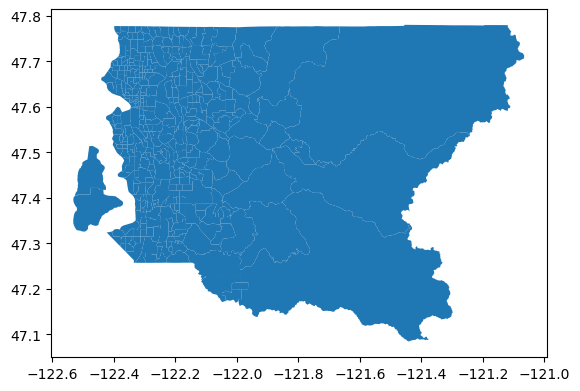

In [14]:
census_gdf.plot()

## Race regrouping

In [15]:
# calculate distribution of race across king county
race_tot = census_gdf[['Race:WhiteAlone', 'Race:BlackAlone', 'Race:AmericanIndianAlaskaNativeAlone', 
                          'Race:AsianAlone', 'Race:NativeHawaiianPacificIslanderAlone',
                          'Race:SomeOtherRaceAlone', 'Race:TwoOrMoreRaces']].sum()
race_tot.sort_values(ascending=False)

Race:WhiteAlone                            1404324
Race:AsianAlone                             386404
Race:BlackAlone                             141790
Race:TwoOrMoreRaces                         140606
Race:SomeOtherRaceAlone                      92377
Race:NativeHawaiianPacificIslanderAlone      16944
Race:AmericanIndianAlaskaNativeAlone         13057
dtype: int64

In [16]:
# create a new column 'Other' containing all races not in the top 3
census_gdf['Race:Other'] = census_gdf[['Race:AmericanIndianAlaskaNativeAlone', 'Race:NativeHawaiianPacificIslanderAlone',
                                       'Race:SomeOtherRaceAlone', 'Race:TwoOrMoreRaces']].sum(axis=1)
# drop unused race columns 
census_gdf.drop(columns=['Race:AmericanIndianAlaskaNativeAlone', 'Race:NativeHawaiianPacificIslanderAlone',
                          'Race:SomeOtherRaceAlone', 'Race:TwoOrMoreRaces'], inplace=True)
census_gdf.head()

,Name,TotalPopulation,Race:WhiteAlone,Race:BlackAlone,Race:AsianAlone,BelowPovertyLevel,Immigration,Umemployment,MedianIncome,MedianGrossRent,MedianHomeValue,ToWork:Car,ToWork:Transit,ToWork:Bike,ToWork:Walk,ToWork:WFH,geometry,Race:Other
Tract,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",4064,2555,434,671,406,556,92,82367,1617,489000,1391,701,0,89,60,"POLYGON ((-122.35608 47.76427, -122.35584 47.7...",404
020800,"Census Tract 208, King County, Washington",4279,3618,64,423,217,121,118,116563,1328,706900,1577,296,40,9,237,"POLYGON ((-122.39346 47.76339, -122.38641 47.7...",174
020900,"Census Tract 209, King County, Washington",3420,2378,342,439,271,358,100,103690,1243,590100,1208,386,22,76,116,"POLYGON ((-122.38711 47.74874, -122.38264 47.7...",261
021000,"Census Tract 210, King County, Washington",6024,3587,455,1254,369,364,74,98083,1752,477600,2508,453,0,65,168,"POLYGON ((-122.34560 47.74869, -122.34548 47.7...",728
022001,"Census Tract 220.01, King County, Washington",5729,4107,35,473,236,347,180,102143,1407,636600,2533,122,23,15,178,"POLYGON ((-122.21347 47.74759, -122.21341 47.7...",1114


In [17]:
race_tot = census_gdf[['Race:WhiteAlone', 'Race:BlackAlone', 'Race:AsianAlone', 
                       'Race:Other']].sum()
race_tot, census_gdf['TotalPopulation'].sum(), race_tot.sum()

(Race:WhiteAlone    1404324
 Race:BlackAlone     141790
 Race:AsianAlone     386404
 Race:Other          262984
 dtype: int64,
 2195502,
 2195502)

## Calculate Area and Density

In [18]:
# project to epsg:32610
census_gdf = gpd.GeoDataFrame(census_gdf, geometry='geometry')
census_proj = census_gdf.to_crs('EPSG:32610')

In [19]:
# calculate area
census_gdf['Area'] = census_proj.geometry.area/1e6

In [20]:
census_gdf['Density'] = census_gdf['TotalPopulation']/census_gdf['Area']

In [21]:
census_gdf.head()

,Name,TotalPopulation,Race:WhiteAlone,Race:BlackAlone,Race:AsianAlone,BelowPovertyLevel,Immigration,Umemployment,MedianIncome,MedianGrossRent,MedianHomeValue,ToWork:Car,ToWork:Transit,ToWork:Bike,ToWork:Walk,ToWork:WFH,geometry,Race:Other,Area,Density
Tract,,,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",4064,2555,434,671,406,556,92,82367,1617,489000,1391,701,0,89,60,"POLYGON ((-122.35608 47.76427, -122.35584 47.7...",404,1.709911,2376.732320
020800,"Census Tract 208, King County, Washington",4279,3618,64,423,217,121,118,116563,1328,706900,1577,296,40,9,237,"POLYGON ((-122.39346 47.76339, -122.38641 47.7...",174,3.801775,1125.527009
020900,"Census Tract 209, King County, Washington",3420,2378,342,439,271,358,100,103690,1243,590100,1208,386,22,76,116,"POLYGON ((-122.38711 47.74874, -122.38264 47.7...",261,5.366515,637.285036
021000,"Census Tract 210, King County, Washington",6024,3587,455,1254,369,364,74,98083,1752,477600,2508,453,0,65,168,"POLYGON ((-122.34560 47.74869, -122.34548 47.7...",728,2.639164,2282.541273
022001,"Census Tract 220.01, King County, Washington",5729,4107,35,473,236,347,180,102143,1407,636600,2533,122,23,15,178,"POLYGON ((-122.21347 47.74759, -122.21341 47.7...",1114,4.452189,1286.782680


## Percentage attributes
* Race: White, Black, Asian, Other
* Below Poverty Level
* Unemployment
* Transportation to Work: Car, Transit, Bike, Walk, WFH

In [22]:
per_attr = ['Race:WhiteAlone', 'Race:BlackAlone', 'Race:AsianAlone', 
            'Race:Other','BelowPovertyLevel', 'Immigration', 
            'Umemployment','ToWork:Car', 'ToWork:Transit', 
            'ToWork:Bike', 'ToWork:Walk', 'ToWork:WFH']

In [23]:
def convert_to_percentages(df, per_attr, total_population_column='TotalPopulation'):
    for column in per_attr:
        new_column_name = '% ' + column
        df[new_column_name] = (df[column] / df[total_population_column]) * 100
        df.drop(column, axis=1, inplace=True)
    return df

In [24]:
census_gdf = convert_to_percentages(census_gdf, per_attr)
census_gdf.head()

,Name,TotalPopulation,MedianIncome,MedianGrossRent,MedianHomeValue,geometry,Area,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH
Tract,,,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",4064,82367,1617,489000,"POLYGON ((-122.35608 47.76427, -122.35584 47.7...",1.709911,2376.732320,62.869094,10.679134,16.510827,9.940945,9.990157,13.681102,2.263780,34.227362,17.249016,0.000000,2.189961,1.476378
020800,"Census Tract 208, King County, Washington",4279,116563,1328,706900,"POLYGON ((-122.39346 47.76339, -122.38641 47.7...",3.801775,1125.527009,84.552466,1.495677,9.885487,4.066371,5.071278,2.827763,2.757654,36.854405,6.917504,0.934798,0.210330,5.538677
020900,"Census Tract 209, King County, Washington",3420,103690,1243,590100,"POLYGON ((-122.38711 47.74874, -122.38264 47.7...",5.366515,637.285036,69.532164,10.000000,12.836257,7.631579,7.923977,10.467836,2.923977,35.321637,11.286550,0.643275,2.222222,3.391813
021000,"Census Tract 210, King County, Washington",6024,98083,1752,477600,"POLYGON ((-122.34560 47.74869, -122.34548 47.7...",2.639164,2282.541273,59.545153,7.553121,20.816733,12.084993,6.125498,6.042497,1.228420,41.633466,7.519920,0.000000,1.079017,2.788845
022001,"Census Tract 220.01, King County, Washington",5729,102143,1407,636600,"POLYGON ((-122.21347 47.74759, -122.21341 47.7...",4.452189,1286.782680,71.687904,0.610927,8.256240,19.444929,4.119393,6.056903,3.141910,44.213650,2.129516,0.401466,0.261826,3.106999


In [25]:
census_gdf.sort_values(by='Density', ascending=False).head()

,Name,TotalPopulation,MedianIncome,MedianGrossRent,MedianHomeValue,geometry,Area,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH
Tract,,,,,,,,,,,,,,,,,,,,
007402,"Census Tract 74.02, King County, Washington",5702,53312,1427,380400,"POLYGON ((-122.32788 47.61670, -122.32788 47.6...",0.249100,22890.402302,67.292178,6.208348,13.416345,13.083129,16.467906,9.505437,2.455279,17.309716,21.010172,2.472817,32.444756,2.928797
007401,"Census Tract 74.01, King County, Washington",5662,78632,1623,356800,"POLYGON ((-122.32824 47.61899, -122.32821 47.6...",0.259192,21844.818392,70.045920,2.931826,19.992935,7.029318,6.146238,12.716355,1.766160,25.079477,24.690922,3.938538,25.379724,4.397739
008002,"Census Tract 80.02, King County, Washington",3785,72155,1642,948600,"POLYGON ((-122.35047 47.61337, -122.34961 47.6...",0.228891,16536.259931,62.245707,8.692206,20.739762,8.322325,16.618230,12.840159,2.879789,15.587847,13.315720,2.192867,21.268164,5.627477
005301,"Census Tract 53.01, King County, Washington",8829,26413,1526,-666666666,"POLYGON ((-122.31780 47.65751, -122.31778 47.6...",0.543084,16257.167724,40.921962,4.054819,42.575603,12.447616,42.394382,31.271945,4.439914,11.496206,14.792162,1.574357,14.984709,2.650357
008300,"Census Tract 83, King County, Washington",3195,68239,1646,437900,"POLYGON ((-122.33272 47.61462, -122.33181 47.6...",0.237273,13465.489152,65.727700,5.477308,23.849765,4.945227,14.679186,19.968701,0.500782,18.341158,14.773083,1.345853,33.615023,3.724570


## Cleaning Negative Values

In [26]:
# numeric columns
num_col = census_gdf.select_dtypes(include=[np.number])

# find rows with negative values in numeric columns
census_gdf[(num_col < 0).any(axis=1)]

,Name,TotalPopulation,MedianIncome,MedianGrossRent,MedianHomeValue,geometry,Area,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH
Tract,,,,,,,,,,,,,,,,,,,,
029206,"Census Tract 292.06, King County, Washington",4272,34857,1146,-666666666,"POLYGON ((-122.27595 47.39829, -122.27581 47.3...",17.414453,245.313478,40.426030,17.626404,5.735019,36.212547,24.204120,22.120787,4.119850,37.125468,5.711610,0.000000,0.819288,0.374532
030313,"Census Tract 303.13, King County, Washington",4416,49291,1234,-666666666,"POLYGON ((-122.33485 47.29291, -122.33483 47.2...",4.008961,1101.532285,58.016304,17.413949,9.601449,14.968297,16.825181,17.051630,3.192935,31.068841,3.238225,0.724638,1.494565,2.060688
005302,"Census Tract 53.02, King County, Washington",5926,17188,1309,-666666666,"POLYGON ((-122.32029 47.65285, -122.31956 47.6...",3.254061,1821.109328,45.545056,3.813702,37.462032,13.179210,1.704354,20.553493,5.669929,3.408707,7.104286,0.337496,12.352346,2.143098
021500,"Census Tract 215, King County, Washington",4821,137321,-666666666,629200,"POLYGON ((-122.29032 47.77595, -122.29031 47.7...",3.910616,1232.798082,82.804397,2.323169,9.126737,5.745696,3.215101,2.675793,2.447625,41.505912,6.658370,0.414852,0.290396,3.650695
005301,"Census Tract 53.01, King County, Washington",8829,26413,1526,-666666666,"POLYGON ((-122.31780 47.65751, -122.31778 47.6...",0.543084,16257.167724,40.921962,4.054819,42.575603,12.447616,42.394382,31.271945,4.439914,11.496206,14.792162,1.574357,14.984709,2.650357


In [27]:
# assign numeric columns
num_cols = census_gdf.select_dtypes(include=[np.number]).columns
# loop through numeric columns
for col in num_cols:
    # Check if there are any negative values
    if (census_gdf[col] < 0).any():
        # Calculate median of the column excluding negative values
        median_val = census_gdf[census_gdf[col] >= 0][col].median()
        # Replace negative values with mean
        census_gdf[col] = census_gdf[col].apply(lambda x: median_val if x < 0 else x)

In [28]:
# find negative value rows
neg_val = (census_gdf[num_cols] < 0).any().any()
# check for negative values in the DataFrame
if neg_val:
    print("Negative values still exist in the DataFrame.")
else:
    print("No negative values found in the DataFrame.")

No negative values found in the DataFrame.


## Ratio attribute
* GrossRent / Income
* HouseValue / Income

In [29]:
house_attr = ['MedianGrossRent','MedianHomeValue']
def convert_to_ratio(df, house_attr, income_column='MedianIncome'):
    for column in house_attr:
        new_column_name = 'Ratio'+column+'ToIncome'
        df[new_column_name] = (df[column] / df[income_column])
        df.drop(column, axis=1, inplace=True)
    return df

In [30]:
census_gdf = convert_to_ratio(census_gdf, house_attr)
census_gdf.head()

,Name,TotalPopulation,MedianIncome,geometry,Area,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH,RatioMedianGrossRentToIncome,RatioMedianHomeValueToIncome
Tract,,,,,,,,,,,,,,,,,,,,
020700,"Census Tract 207, King County, Washington",4064,82367,"POLYGON ((-122.35608 47.76427, -122.35584 47.7...",1.709911,2376.732320,62.869094,10.679134,16.510827,9.940945,9.990157,13.681102,2.263780,34.227362,17.249016,0.000000,2.189961,1.476378,0.019632,5.936844
020800,"Census Tract 208, King County, Washington",4279,116563,"POLYGON ((-122.39346 47.76339, -122.38641 47.7...",3.801775,1125.527009,84.552466,1.495677,9.885487,4.066371,5.071278,2.827763,2.757654,36.854405,6.917504,0.934798,0.210330,5.538677,0.011393,6.064532
020900,"Census Tract 209, King County, Washington",3420,103690,"POLYGON ((-122.38711 47.74874, -122.38264 47.7...",5.366515,637.285036,69.532164,10.000000,12.836257,7.631579,7.923977,10.467836,2.923977,35.321637,11.286550,0.643275,2.222222,3.391813,0.011988,5.691002
021000,"Census Tract 210, King County, Washington",6024,98083,"POLYGON ((-122.34560 47.74869, -122.34548 47.7...",2.639164,2282.541273,59.545153,7.553121,20.816733,12.084993,6.125498,6.042497,1.228420,41.633466,7.519920,0.000000,1.079017,2.788845,0.017862,4.869345
022001,"Census Tract 220.01, King County, Washington",5729,102143,"POLYGON ((-122.21347 47.74759, -122.21341 47.7...",4.452189,1286.782680,71.687904,0.610927,8.256240,19.444929,4.119393,6.056903,3.141910,44.213650,2.129516,0.401466,0.261826,3.106999,0.013775,6.232439


In [31]:
census_gdf.drop(columns=['TotalPopulation','MedianIncome','Area'], inplace =True)

In [32]:
census_gdf.columns

Index(['Name', 'geometry', 'Density', '% Race:WhiteAlone', '% Race:BlackAlone',
       '% Race:AsianAlone', '% Race:Other', '% BelowPovertyLevel',
       '% Immigration', '% Umemployment', '% ToWork:Car', '% ToWork:Transit',
       '% ToWork:Bike', '% ToWork:Walk', '% ToWork:WFH',
       'RatioMedianGrossRentToIncome', 'RatioMedianHomeValueToIncome'],
      dtype='object')

# Visualization

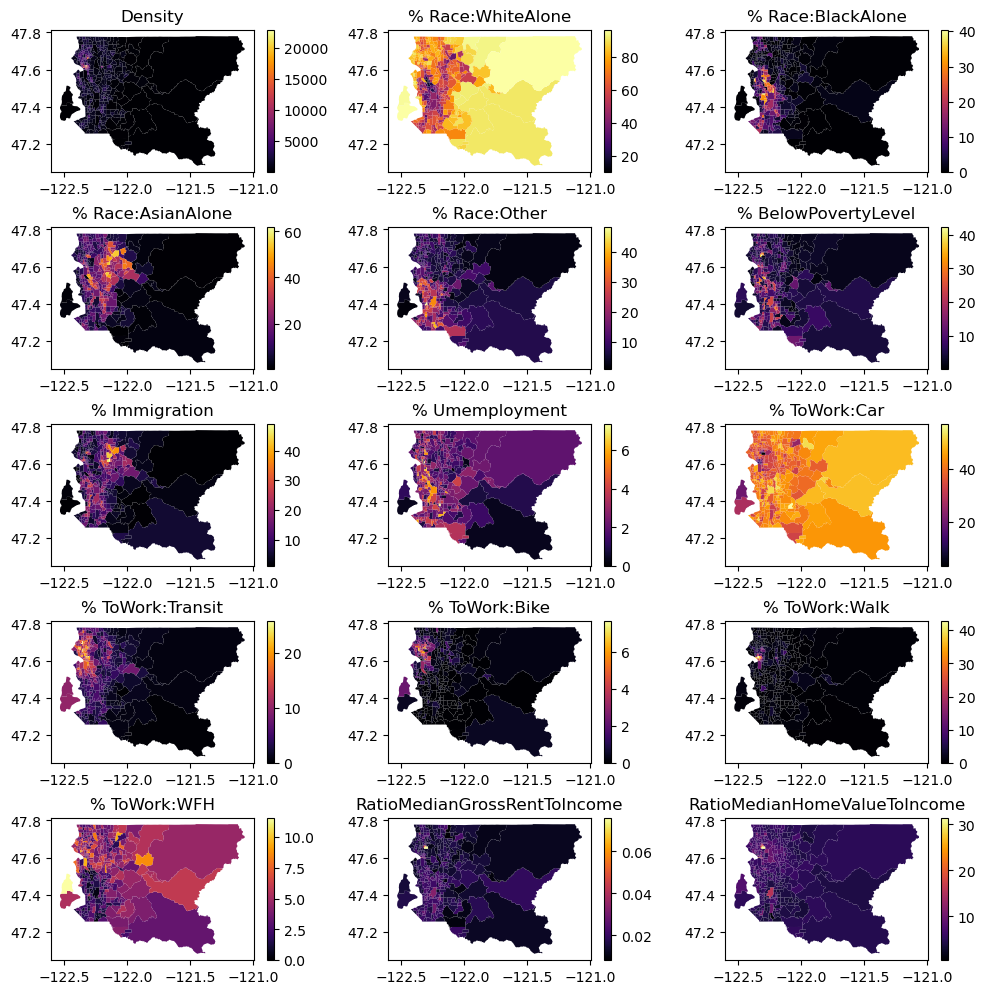

In [33]:
# create subplots
f, ax = plt.subplots(5,3,figsize=(10, 10))

# Flatten the axes array to simplify indexing
ax = ax.flatten()

# Iterate over the columns excluding 'Name' and 'geometry'
for i, col in enumerate(census_gdf.columns[2:]):
    # Plot the column
    census_gdf.plot(ax=ax[i], column=col, cmap='inferno', legend=True)
    # Set title for the subplot
    ax[i].set_title(col)
plt.tight_layout()

# Individual Demographic Analysis

## Population Density

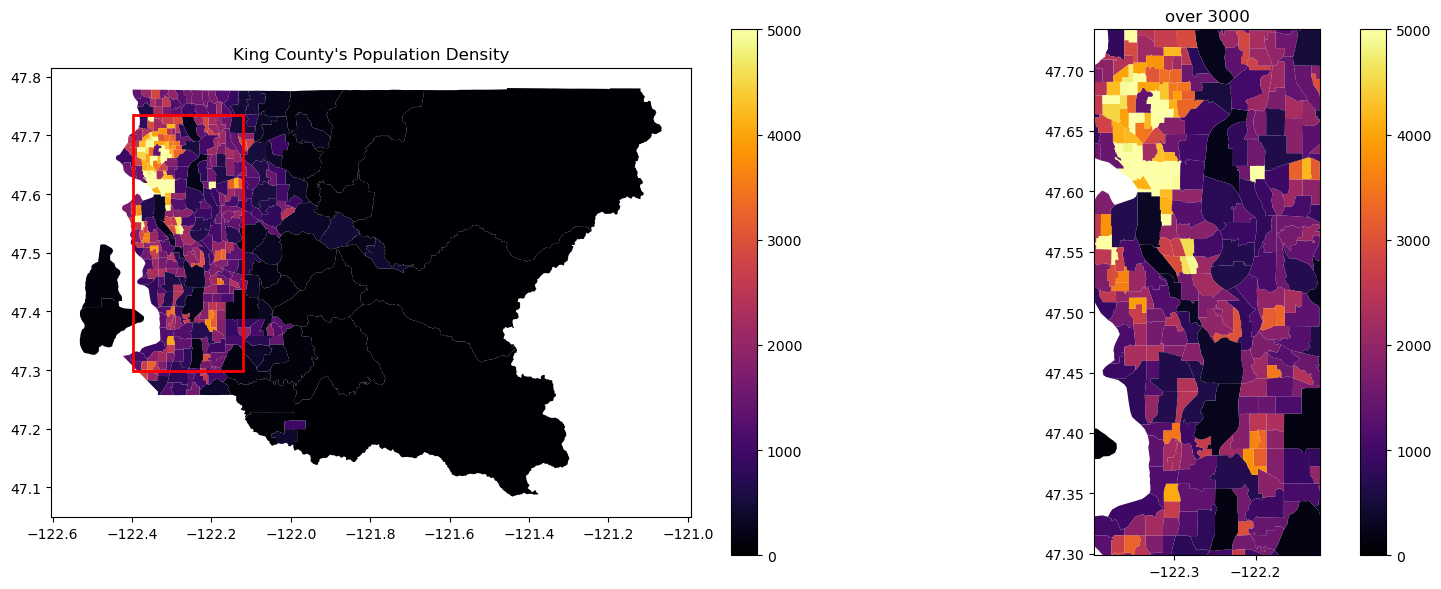

In [125]:
# Filter the census_gdf to select areas with high density (for example, density > 3000)
high_density_areas = census_gdf[census_gdf['Density'] > 3000]

# Get the bounding box of high density areas
bbox = high_density_areas.total_bounds

# Plot a rectangle around the high density areas
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plote Population Density 
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='Density',cmap='inferno',legend=True ,vmin=0,vmax=5000)
ax[0].set_title("King County's Population Density")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='Density',cmap='inferno',legend=True ,vmin=0,vmax=5000)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 3000")
plt.tight_layout()

## Race

In [96]:
race_col = ['% Race:WhiteAlone', '% Race:BlackAlone', '% Race:AsianAlone', '% Race:Other']

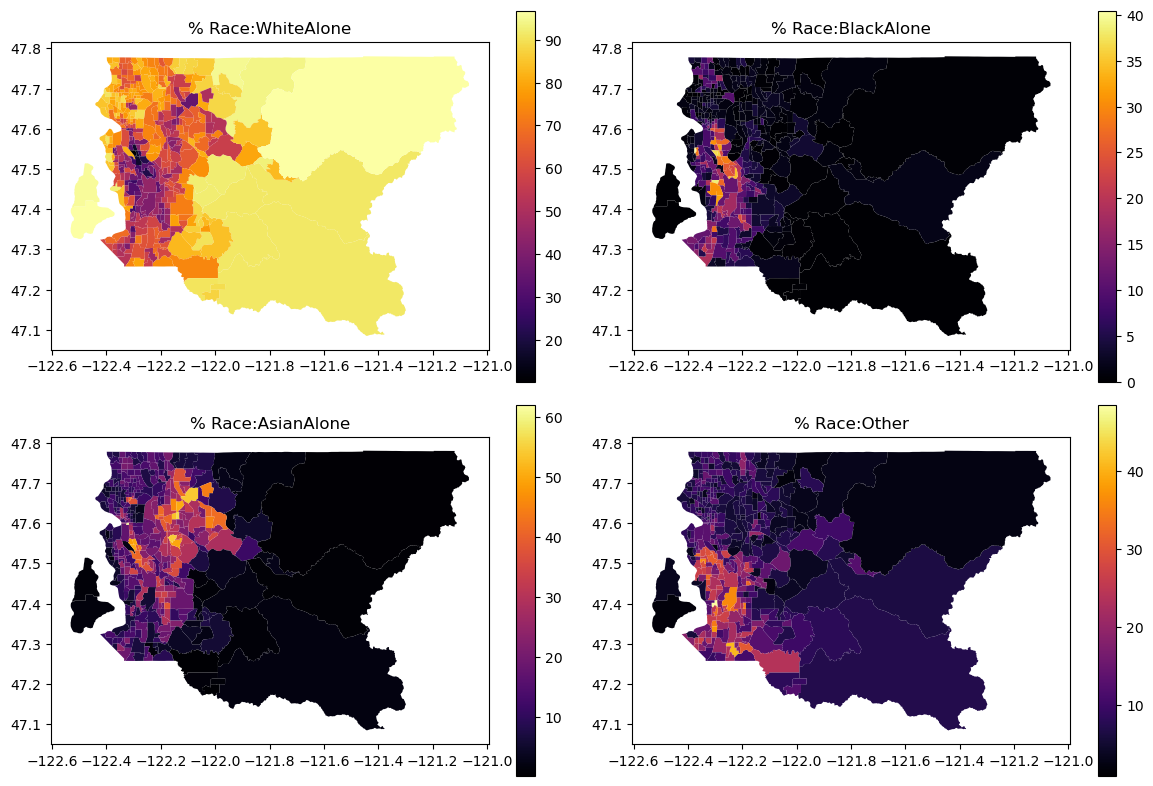

In [101]:
# create subplots
f, ax = plt.subplots(2,2,figsize=(12, 8))

# Flatten the axes array to simplify indexing
ax = ax.flatten()

# Iterate over the columns excluding 'Name' and 'geometry'
for i, col in enumerate(race_col):
    # Plot the column
    census_gdf.plot(ax=ax[i], column=col, cmap='inferno', legend=True)
    # Set title for the subplot
    ax[i].set_title(col)
plt.tight_layout()

## Below Poverty

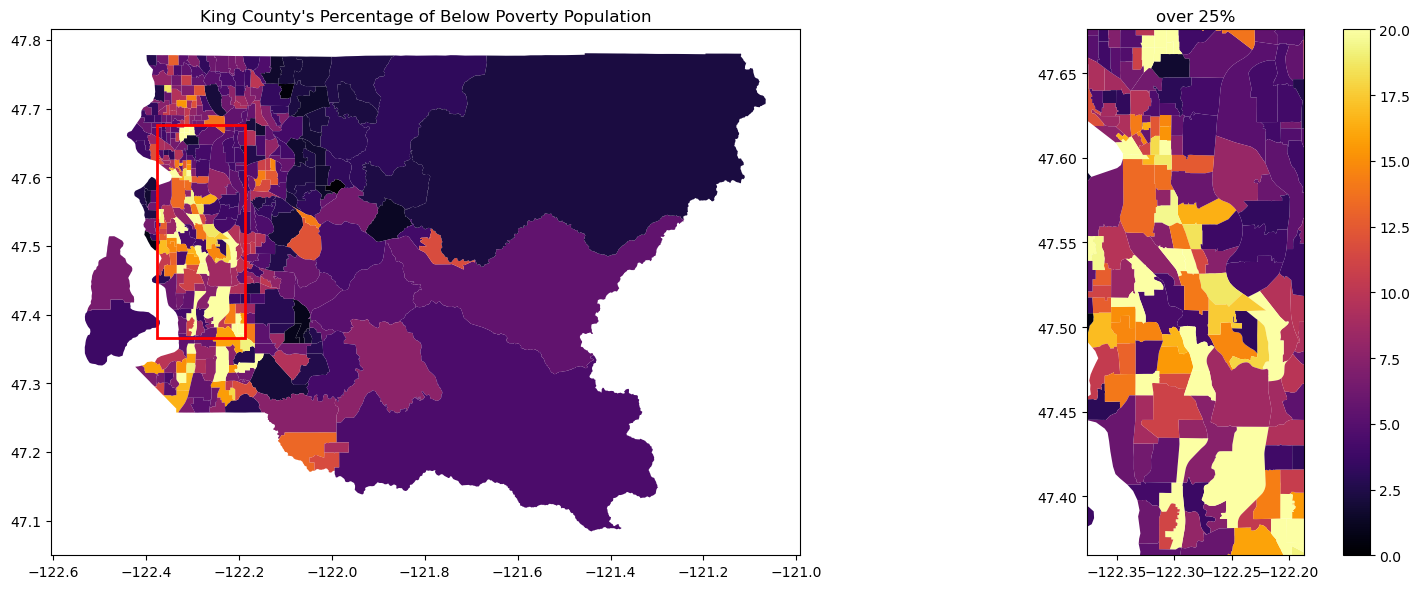

In [126]:
# Filter the census_gdf to select areas with below poverty pop more than 25%
below_pov_areas = census_gdf[census_gdf['% BelowPovertyLevel'] > 25]

# Get the bounding box of below poverty areas
bbox = below_pov_areas.total_bounds

# Plot a rectangle around the high percentage of below poverty population
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plot Below Poverty Population 
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='% BelowPovertyLevel',cmap='inferno',vmin=0,vmax=20)
ax[0].set_title("King County's Percentage of Below Poverty Population")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='% BelowPovertyLevel',cmap='inferno',legend=True ,vmin=0,vmax=20)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 25%")
plt.tight_layout()


## Immigration

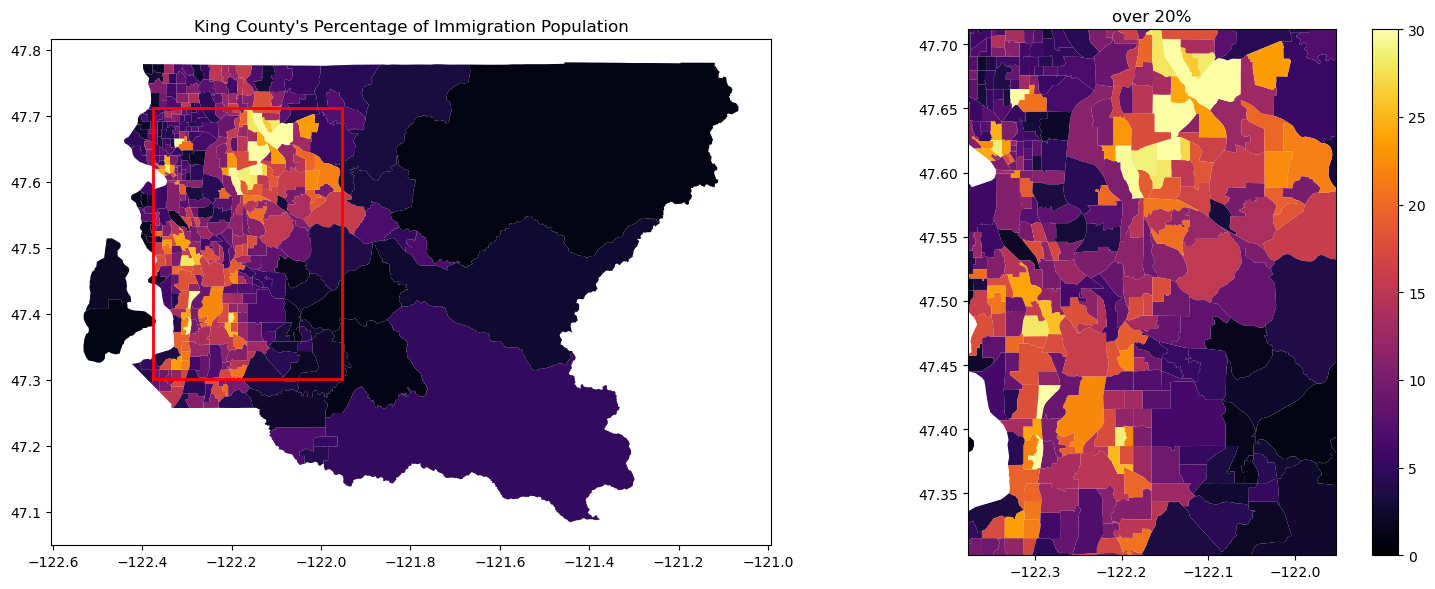

In [127]:
# Filter the census_gdf to select areas with below poverty pop more than 20%
immigr_areas = census_gdf[census_gdf['% Immigration'] > 20]

# Get the bounding box of immigration areas
bbox = immigr_areas.total_bounds

# Plot a rectangle around the high percentage of immigration
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plot Percentage of Immigration 
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='% Immigration',cmap='inferno',vmin=0,vmax=30)
ax[0].set_title("King County's Percentage of Immigration Population")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='% Immigration',cmap='inferno',legend=True ,vmin=0,vmax=30)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 20%")
plt.tight_layout()


# Unemployment

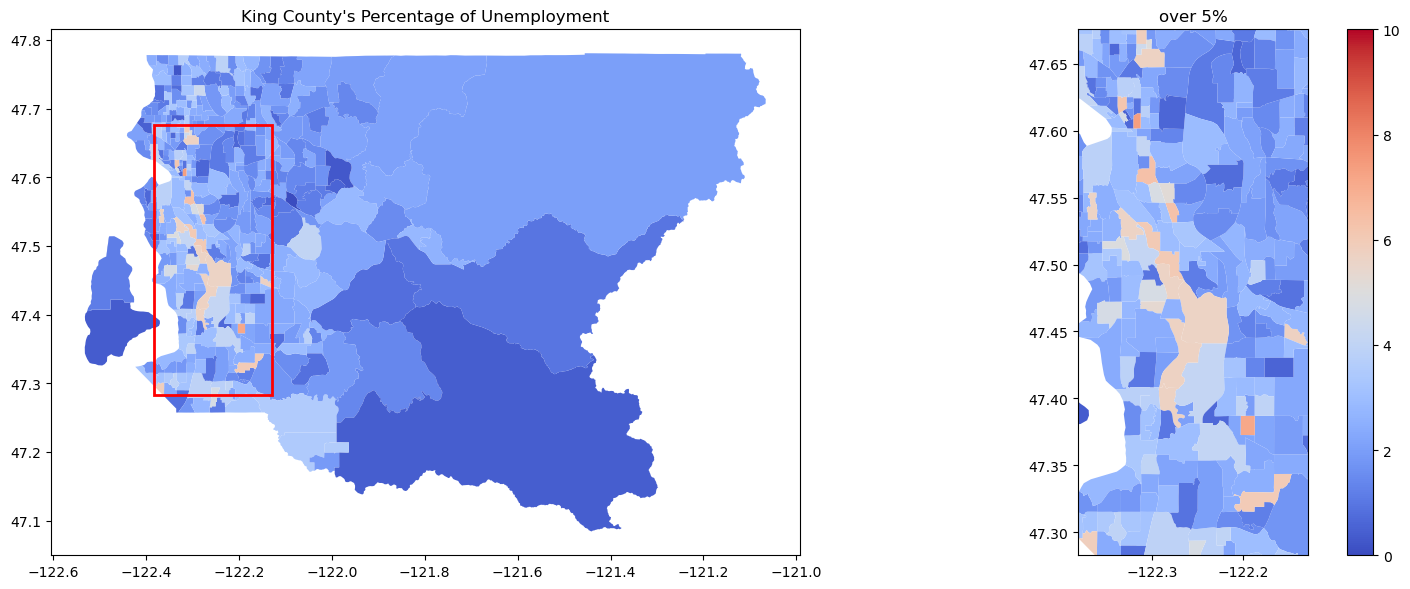

In [183]:
# Filter the census_gdf to select areas with below poverty pop more than 20%
unemp_areas = census_gdf[census_gdf['% Umemployment'] > 5]

# Get the bounding box of immigration areas
bbox = unemp_areas.total_bounds

# Plot a rectangle around the high percentage of immigration
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plot Percentage of Immigration 
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='% Umemployment',cmap='coolwarm',vmin=0,vmax=10)
ax[0].set_title("King County's Percentage of Unemployment")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='% Umemployment',cmap='coolwarm',legend=True ,vmin=0,vmax=10)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 5%")
plt.tight_layout()


## Transportation to Work

In [145]:
trans_col = ['% ToWork:Car', '% ToWork:Transit','% ToWork:Bike', '% ToWork:Walk', '% ToWork:WFH']

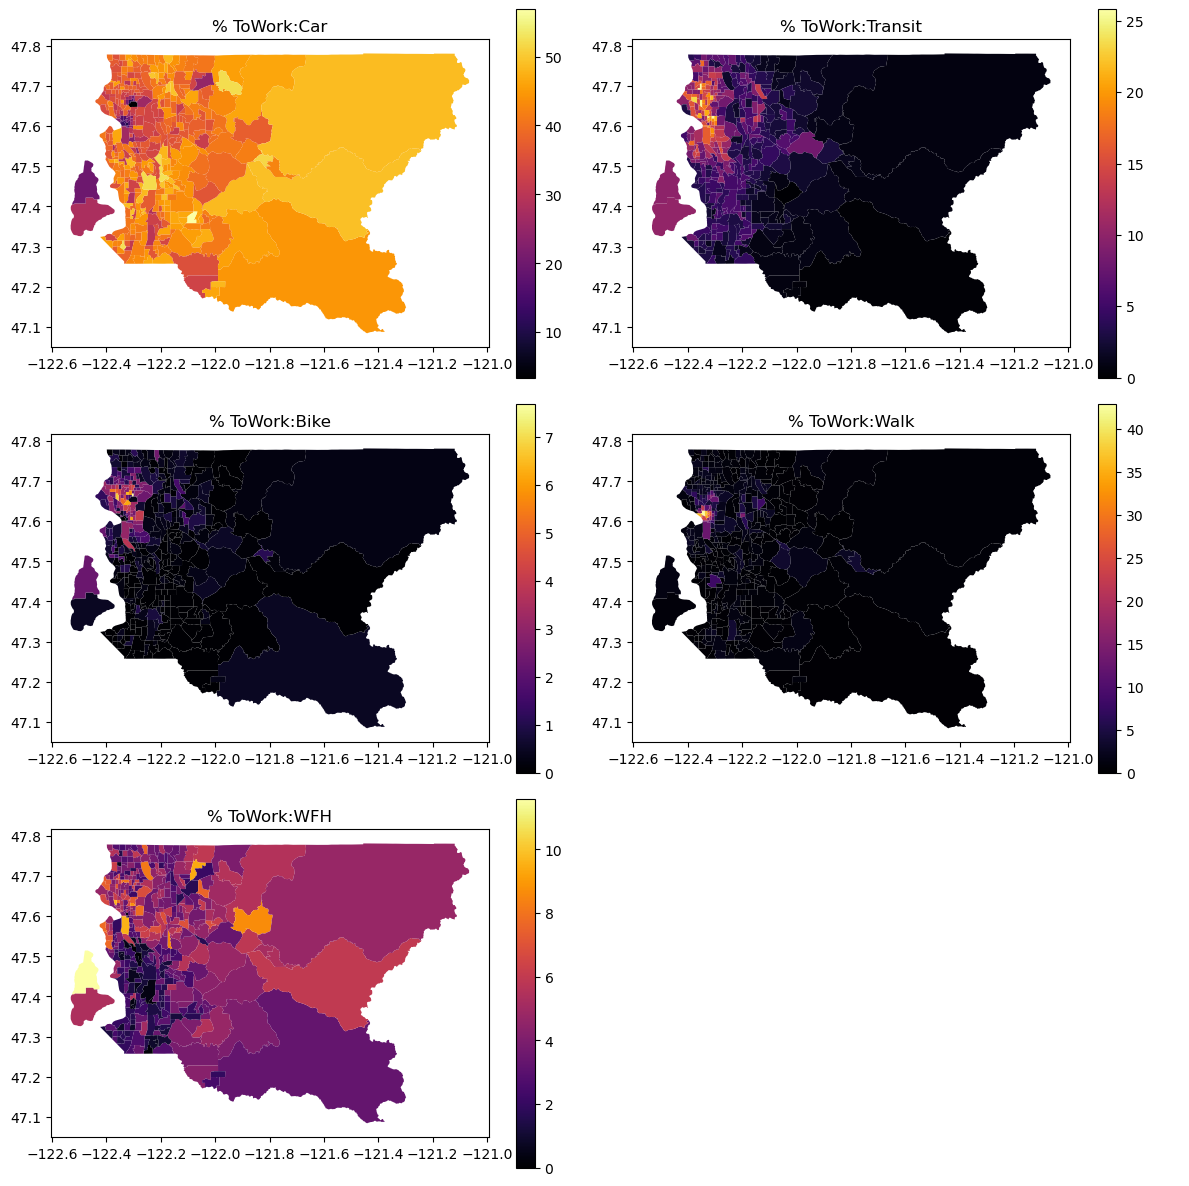

In [161]:
# create subplots
f, ax = plt.subplots(3,2,figsize=(12, 12))

# Flatten the axes array to simplify indexing
ax = ax.flatten()

# Iterate over the columns excluding 'Name' and 'geometry'
for i, col in enumerate(trans_col):
    # Plot the column
    census_gdf.plot(ax=ax[i], column=col, cmap='inferno', legend=True)
    # Set title for the subplot
    ax[i].set_title(col)
for j in range(len(trans_col), len(ax)):
    ax[j].axis('off')
plt.tight_layout()

# MedianGrossRent to Income Ratio

In [173]:
# multiply by 12 to reflect yearly ratio
census_gdf['RatioMedianGrossRentToIncome'] = census_gdf['RatioMedianGrossRentToIncome'] * 12

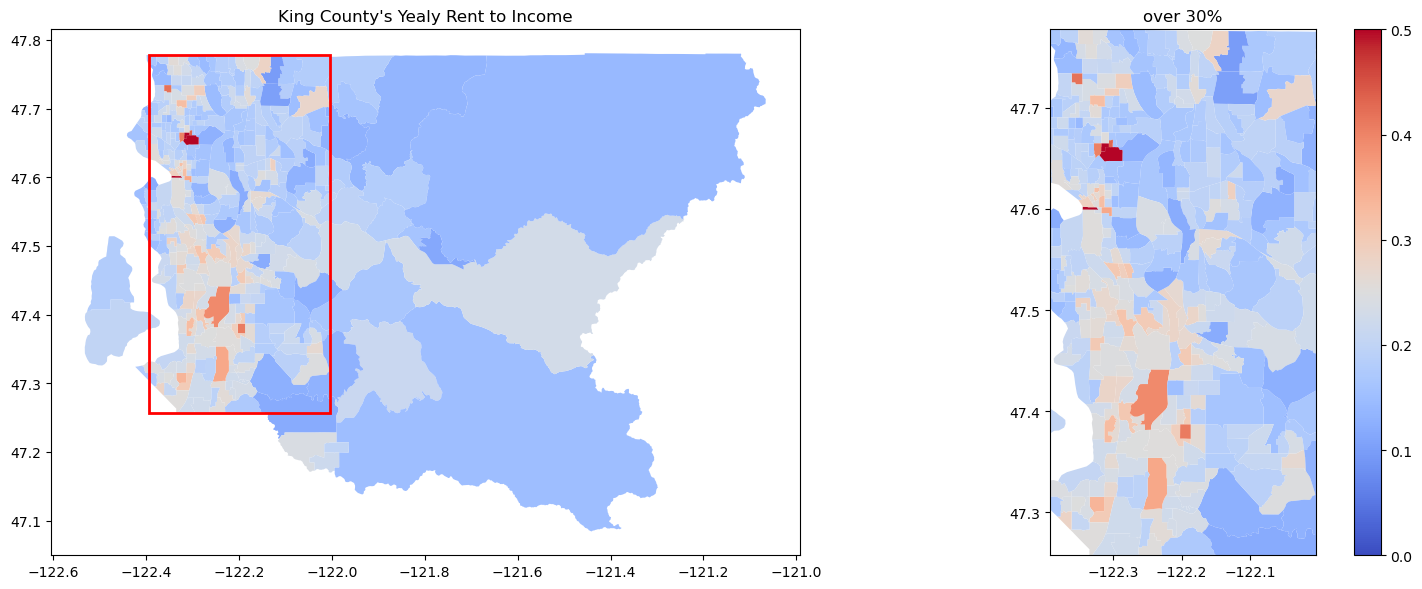

In [184]:
# Filter the census_gdf to select areas with high MedianGrossRent to Income Ratio
rti_areas = census_gdf[census_gdf['RatioMedianGrossRentToIncome'] > 0.25]

# Get the bounding box of high MedianGrossRent to Income Ratio
bbox = rti_areas.total_bounds

# Plot a rectangle around the high MedianGrossRent to Income Ratio
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plot MedianGrossRent to Income Ratio
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='RatioMedianGrossRentToIncome',cmap='coolwarm',vmin=0,vmax=0.5)
ax[0].set_title("King County's Yealy Rent to Income")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='RatioMedianGrossRentToIncome',cmap='coolwarm',legend=True ,vmin=0,vmax=0.5)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 30%")
plt.tight_layout()

## Median Home Value To Income Ratio

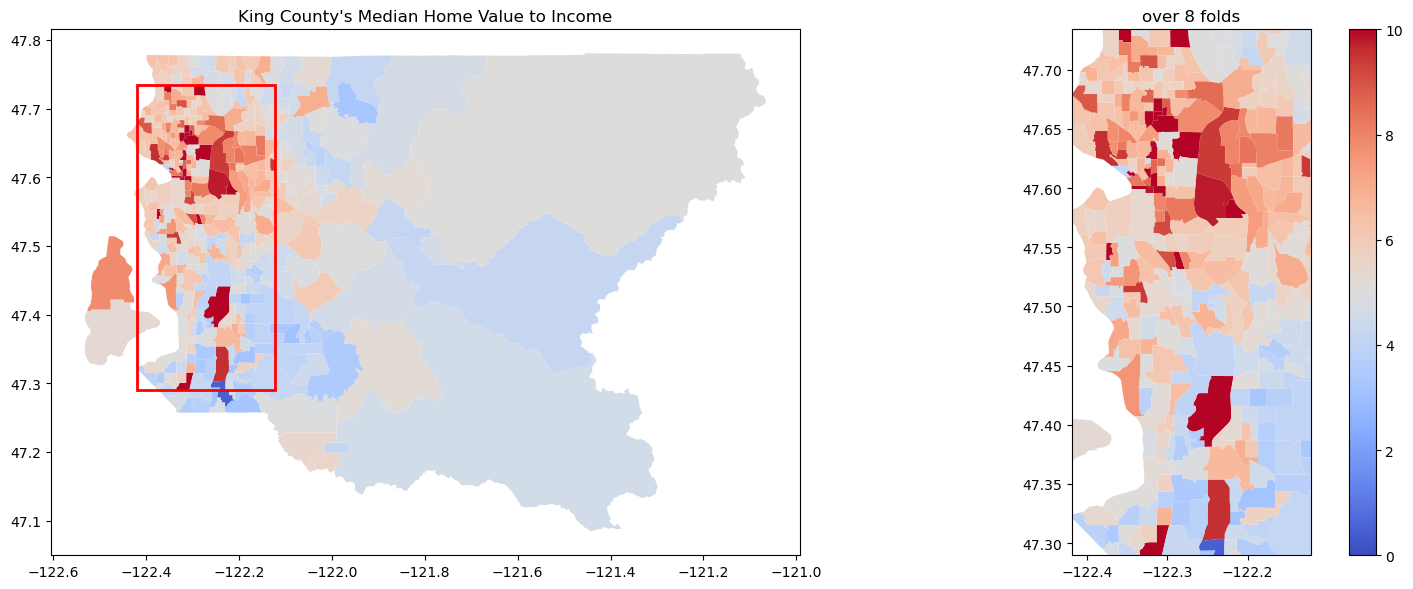

In [192]:
# Filter the census_gdf to select areas with highMedian Home Value 
rti_areas = census_gdf[census_gdf['RatioMedianHomeValueToIncome'] > 8]

# Get the bounding box of high MedianGrossRent to Income Ratio
bbox = rti_areas.total_bounds

# Plot a rectangle around the high MedianGrossRent to Income Ratio
rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    linewidth=2, edgecolor='red', facecolor='none')

# Plot Median Home Value  to Income Ratio
f, ax = plt.subplots(1,2,figsize=(15, 6))
census_gdf.plot(ax=ax[0],column='RatioMedianHomeValueToIncome',cmap='coolwarm',vmin=0,vmax=10)
ax[0].set_title("King County's Median Home Value to Income")
ax[0].add_patch(rect)

census_gdf.plot(ax=ax[1],column='RatioMedianHomeValueToIncome',cmap='coolwarm',legend=True ,vmin=0,vmax=10)
ax[1].set_xlim(bbox[0], bbox[2])
ax[1].set_ylim(bbox[1], bbox[3])
ax[1].set_title("over 8 folds")
plt.tight_layout()

## Correlation
* need to combine with other analysis

In [193]:
corr = census_gdf.corr(numeric_only=True)
corr

,Density,% Race:WhiteAlone,% Race:BlackAlone,% Race:AsianAlone,% Race:Other,% BelowPovertyLevel,% Immigration,% Umemployment,% ToWork:Car,% ToWork:Transit,% ToWork:Bike,% ToWork:Walk,% ToWork:WFH,RatioMedianGrossRentToIncome,RatioMedianHomeValueToIncome
Density,1.000000,-0.096884,0.081583,0.104920,-0.018657,0.342663,0.169566,0.124704,-0.577921,0.632374,0.427292,0.757865,0.025167,0.325524,0.375833
% Race:WhiteAlone,-0.096884,1.000000,-0.709187,-0.666718,-0.559453,-0.511497,-0.616389,-0.334190,0.053346,-0.034370,0.259987,-0.010686,0.523399,-0.411036,-0.116677
% Race:BlackAlone,0.081583,-0.709187,1.000000,0.121511,0.432258,0.580101,0.168601,0.355638,-0.077052,0.111888,-0.127884,-0.025990,-0.433476,0.320860,0.098107
% Race:AsianAlone,0.104920,-0.666718,0.121511,1.000000,-0.110630,0.113921,0.649641,0.040207,-0.120514,0.046782,-0.173103,0.103504,-0.165629,0.177416,0.156802
% Race:Other,-0.018657,-0.559453,0.432258,-0.110630,1.000000,0.411364,0.252692,0.342848,0.135538,-0.102482,-0.201374,-0.104872,-0.505213,0.345321,-0.067779
% BelowPovertyLevel,0.342663,-0.511497,0.580101,0.113921,0.411364,1.000000,0.321395,0.389289,-0.386392,0.285648,0.110361,0.202085,-0.348486,0.522613,0.437304
% Immigration,0.169566,-0.616389,0.168601,0.649641,0.252692,0.321395,1.000000,0.121348,-0.113980,0.053467,-0.172390,0.195429,-0.297220,0.303824,0.161126
% Umemployment,0.124704,-0.334190,0.355638,0.040207,0.342848,0.389289,0.121348,1.000000,-0.126842,0.132802,0.061228,0.109354,-0.336718,0.332202,0.211632
% ToWork:Car,-0.577921,0.053346,-0.077052,-0.120514,0.135538,-0.386392,-0.113980,-0.126842,1.000000,-0.543003,-0.404145,-0.661791,-0.240859,-0.341561,-0.626287
% ToWork:Transit,0.632374,-0.034370,0.111888,0.046782,-0.102482,0.285648,0.053467,0.132802,-0.543003,1.000000,0.659906,0.473211,0.172413,0.152697,0.398315


* If we can see which demographic have highly correlations on flow and land uses, we can identify areas that we 